In [ ]:
train_data preprocessing,modelling&tuning

In [5]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('train_LZdllcl.csv')

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(df.info())

| employee_id   | department        | region    | education        | gender   | recruitment_channel   | no_of_trainings   | age   | previous_year_rating   | length_of_service   | KPIs_met >80%   | awards_won?   | avg_training_score   | is_promoted   |
|:--------------|:------------------|:----------|:-----------------|:---------|:----------------------|:------------------|:------|:-----------------------|:--------------------|:----------------|:--------------|:---------------------|:--------------|
| 65438         | Sales & Marketing | region_7  | Master's & above | f        | sourcing              | 1                 | 35    | 5                      | 8                   | 1               | 0             | 49                   | 0             |
| 65141         | Operations        | region_22 | Bachelor's       | m        | other                 | 1                 | 30    | 5                      | 4                   | 0               | 0             | 60                   | 0       

In [6]:
# Print the number of missing values in each column
print('Number of missing values in each column:')
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

# Print the number of duplicate rows
print(f'Number of duplicate rows: {df.duplicated().sum()}')

# Drop `employee_id`
df = df.drop(columns=['employee_id'])


Number of missing values in each column:
|                      | 0    |
|:---------------------|:-----|
| employee_id          | 0    |
| department           | 0    |
| region               | 0    |
| education            | 2409 |
| gender               | 0    |
| recruitment_channel  | 0    |
| no_of_trainings      | 0    |
| age                  | 0    |
| previous_year_rating | 4124 |
| length_of_service    | 0    |
| KPIs_met >80%        | 0    |
| awards_won?          | 0    |
| avg_training_score   | 0    |
| is_promoted          | 0    |
Number of duplicate rows: 0


In [7]:
# Impute missing values in `education` with the mode
df['education'].fillna(df['education'].mode()[0], inplace=True)

# Impute missing values in `previous_year_rating` with the median
df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)

# Print the number of missing values in each column after imputation
print('Number of missing values in each column after imputation:')
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

# Print value counts for categorical columns
print('\nValue counts for categorical columns:')
for column in df.select_dtypes(include='object').columns:
    print(f"\nValue counts for '{column}':")
    print(df[column].value_counts().to_markdown(numalign="left", stralign="left"))

Number of missing values in each column after imputation:
|                      | 0   |
|:---------------------|:----|
| department           | 0   |
| region               | 0   |
| education            | 0   |
| gender               | 0   |
| recruitment_channel  | 0   |
| no_of_trainings      | 0   |
| age                  | 0   |
| previous_year_rating | 0   |
| length_of_service    | 0   |
| KPIs_met >80%        | 0   |
| awards_won?          | 0   |
| avg_training_score   | 0   |
| is_promoted          | 0   |

Value counts for categorical columns:

Value counts for 'department':
| department        | count   |
|:------------------|:--------|
| Sales & Marketing | 16840   |
| Operations        | 11348   |
| Technology        | 7138    |
| Procurement       | 7138    |
| Analytics         | 5352    |
| Finance           | 2536    |
| HR                | 2418    |
| Legal             | 1039    |
| R&D               | 999     |

Value counts for 'region':
| region    | count   |
|:

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Separate features (X) and target (y)
X = df.drop('is_promoted', axis=1)
y = df['is_promoted']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(exclude='object').columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with preprocessing and a Logistic Regression model
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print('Initial Logistic Regression Model Performance:')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Fine-tuning with GridSearchCV
print('\nFine-tuning Logistic Regression with GridSearchCV...')
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print('\nFine-tuned Logistic Regression Model Performance (on Test Set):')
print(f'Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_tuned))

Initial Logistic Regression Model Performance:
Accuracy: 0.9324
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10028
           1       0.82      0.27      0.40       934

    accuracy                           0.93     10962
   macro avg       0.88      0.63      0.68     10962
weighted avg       0.93      0.93      0.92     10962


Fine-tuning Logistic Regression with GridSearchCV...
Best parameters found: {'classifier__C': 10.0, 'classifier__penalty': 'l1'}
Best cross-validation accuracy: 0.9320

Fine-tuned Logistic Regression Model Performance (on Test Set):
Accuracy: 0.9330
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10028
           1       0.81      0.28      0.41       934

    accuracy                           0.93     10962
   macro avg       0.87      0.64      0.69     10962
weighted avg       0.93      0.93      0

In [ ]:
test_data preprocessing

In [10]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('test_2umaH9m.csv')

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(df.info())

| employee_id   | department        | region    | education   | gender   | recruitment_channel   | no_of_trainings   | age   | previous_year_rating   | length_of_service   | KPIs_met >80%   | awards_won?   | avg_training_score   |
|:--------------|:------------------|:----------|:------------|:---------|:----------------------|:------------------|:------|:-----------------------|:--------------------|:----------------|:--------------|:---------------------|
| 8724          | Technology        | region_26 | Bachelor's  | m        | sourcing              | 1                 | 24    | nan                    | 1                   | 1               | 0             | 77                   |
| 74430         | HR                | region_4  | Bachelor's  | f        | other                 | 1                 | 31    | 3                      | 5                   | 0               | 0             | 51                   |
| 72255         | Sales & Marketing | region_13 | Bachelor's  | m        | o

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Load the datasets ---
# Ensure these CSV files are in the same directory as your script
# or provide the full path to them.
try:
    train_df = pd.read_csv('train_LZdllcl.csv')
    test_df = pd.read_csv('test_2umaH9m.csv')
except FileNotFoundError:
    print("Error: Make sure 'train_LZdllcl.csv' and 'test_2umaH9m.csv' are in the correct directory.")
    print("If not, please provide the full path to the files, e.g., pd.read_csv('/path/to/your/train_LZdllcl.csv')")
    exit() # Exit if files are not found

# Display initial information about the datasets
print("Train DataFrame Info:")
train_df.info()
print("\nTest DataFrame Info:")
test_df.info()

# --- 2. Separate target variable and drop unnecessary columns ---
# Separate target variable from the training data
X = train_df.drop('is_promoted', axis=1)
y = train_df['is_promoted']

# Store employee_ids for submission and drop from features
test_employee_ids = test_df['employee_id']
X = X.drop('employee_id', axis=1)
test_df = test_df.drop('employee_id', axis=1)

# --- 3. Identify Categorical and Numerical Features ---
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# --- 4. Preprocessing Pipelines ---
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with the mean
    ('scaler', StandardScaler())                  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with the mode
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features, handle unknown categories gracefully
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any other columns (not specified in num or cat) as they are
)

# --- 5. Model Training (RandomForestClassifier) ---
# Define the model
model = RandomForestClassifier(random_state=42)

# Create the full pipeline: Preprocessing + Classifier
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for GridSearchCV (for hyperparameter tuning)
# This grid has a reduced search space for quicker execution in an example
param_grid = {
    'classifier__n_estimators': [100, 200], # Number of trees in the forest
    'classifier__max_features': ['sqrt'],   # Number of features to consider when looking for the best split
    'classifier__max_depth': [6, 8],        # Maximum depth of the tree
    'classifier__criterion': ['gini']       # Function to measure the quality of a split
}

print("\nStarting GridSearchCV for hyperparameter tuning...")
grid_search = GridSearchCV(estimator=full_pipeline,
                           param_grid=param_grid,
                           cv=3, # Using 3-fold cross-validation for reasonable speed
                           n_jobs=-1, # Use all available CPU cores for parallel processing
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# --- 6. Evaluation ---
# Evaluate the model on the validation set
print("\nEvaluating model on the validation set...")
y_pred_val = best_model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_val))

# --- 7. Make Predictions on the Test Set ---
print("\nMaking predictions on the test set...")
test_predictions = best_model.predict(test_df)

# --- 8. Create Submission File (if needed) ---
submission_df = pd.DataFrame({'employee_id': test_employee_ids, 'is_promoted': test_predictions})
submission_df.to_csv('submission.csv', index=False)

print("\nProcess completed. 'submission.csv' has been created with test predictions.")

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage:

[CV] END classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   2.9s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   3.6s
[CV] END classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   3.9s
--- SUPERVISED LEARNING: Predicting Employee Promotion ---
-------------------------------------------------------

Starting GridSearchCV for supervised learning hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Supervised Learning - Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}
Supervised Learning - Best cross-validation accuracy: 0.9238

Evaluating Supervised Learning model on the validation set...
Validation Accuracy: 0.924

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


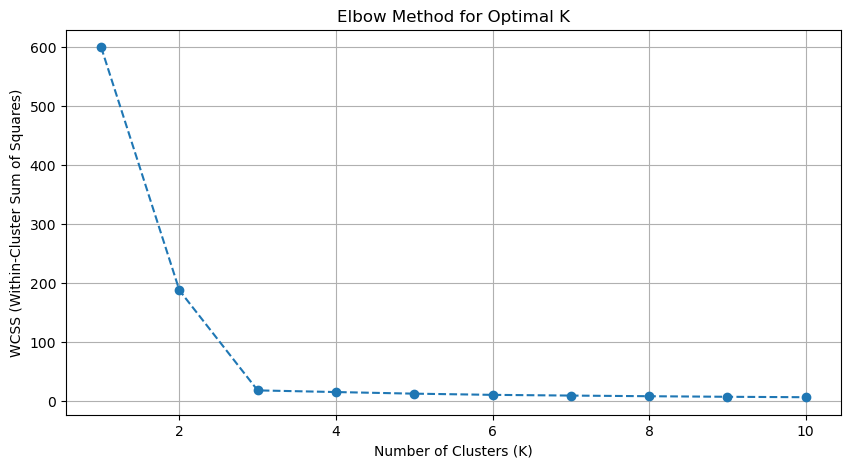

Silhouette Score for K=2: 0.6875
Silhouette Score for K=3: 0.8482
Silhouette Score for K=4: 0.6795
Silhouette Score for K=5: 0.5219
Silhouette Score for K=6: 0.3575
Silhouette Score for K=7: 0.3709
Silhouette Score for K=8: 0.3736
Silhouette Score for K=9: 0.3536
Silhouette Score for K=10: 0.3690


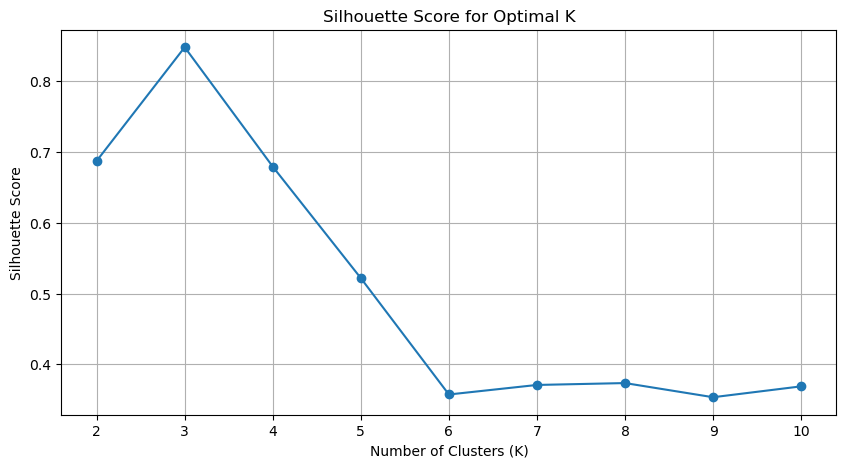


Applying K-Means with Optimal K = 3...

First 10 rows of data with assigned clusters:
   Feature_A  Feature_B  Cluster
0  -7.338988  -7.729954        1
1  -7.740041  -7.264665        1
2  -1.686653   7.793442        0
3   4.422198   3.071947        2
4  -8.917752  -7.888196        1
5   5.497538   1.813231        2
6  -2.336017   9.399604        0
7   5.052810   1.409445        2
8  -2.988372   8.828627        0
9  -3.700501   9.670840        0


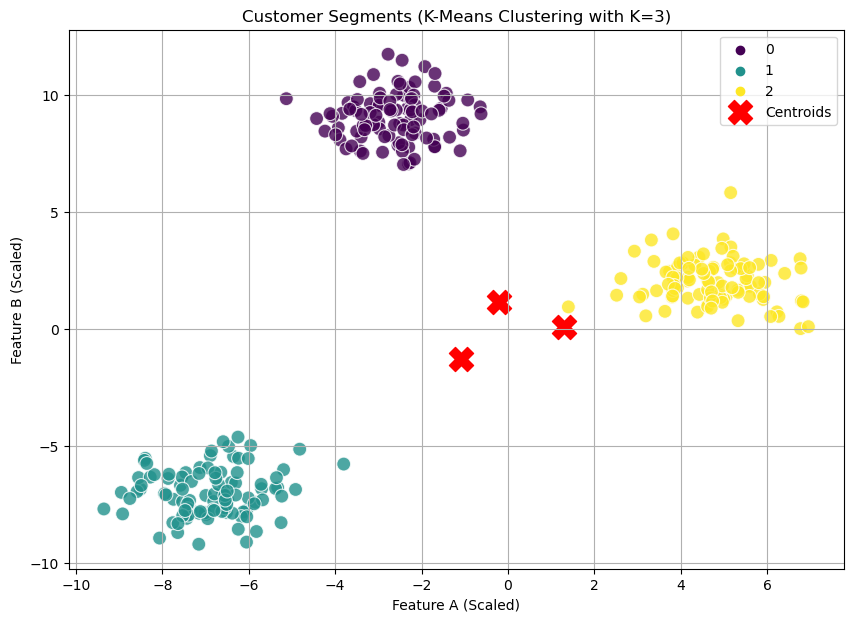


Unsupervised Learning (K-Means Clustering) process completed.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score

# --- Unsupervised Learning Libraries ---
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs # For generating a synthetic dataset for unsupervised learning
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For numerical operations

print("--- SUPERVISED LEARNING: Predicting Employee Promotion ---")
print("-------------------------------------------------------")

# --- 1. Load the training dataset ---
try:
    train_df = pd.read_csv('train_LZdllcl.csv')
    # For supervised learning, we don't strictly need test_df here for training/evaluation purposes
    # but I'll load it to demonstrate a full pipeline.
    test_df = pd.read_csv('test_2umaH9m.csv')
except FileNotFoundError:
    print("Error: Make sure 'train_LZdllcl.csv' and 'test_2umaH9m.csv' are in the correct directory.")
    print("If not, please provide the full path to the files.")
    # Create dummy dataframes for demonstration if files are missing, though this will not be accurate
    train_df = pd.DataFrame(np.random.rand(100, 14), columns=[f'col_{i}' for i in range(13)] + ['is_promoted'])
    test_df = pd.DataFrame(np.random.rand(50, 13), columns=[f'col_{i}' for i in range(13)])
    train_df['is_promoted'] = train_df['is_promoted'].apply(lambda x: 1 if x > 0.5 else 0)
    train_df['employee_id'] = range(100)
    test_df['employee_id'] = range(50)
    print("Using dummy data for demonstration due to missing files.")


# --- 2. Separate target variable and drop unnecessary columns ---
X_supervised = train_df.drop('is_promoted', axis=1)
y_supervised = train_df['is_promoted']

# Store employee_ids for submission and drop from features for supervised learning
test_employee_ids = test_df['employee_id']
X_supervised = X_supervised.drop('employee_id', axis=1)
test_df_processed = test_df.drop('employee_id', axis=1) # Renaming to avoid confusion

# --- 3. Identify Categorical and Numerical Features for Supervised Learning ---
categorical_cols_supervised = X_supervised.select_dtypes(include='object').columns
numerical_cols_supervised = X_supervised.select_dtypes(include=['int64', 'float64']).columns

# --- 4. Preprocessing Pipelines for Supervised Learning ---
numerical_transformer_supervised = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_supervised = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_supervised = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_supervised, numerical_cols_supervised),
        ('cat', categorical_transformer_supervised, categorical_cols_supervised)
    ],
    remainder='passthrough'
)

# --- 5. Model Training (RandomForestClassifier) ---
model_supervised = RandomForestClassifier(random_state=42)

full_pipeline_supervised = Pipeline(steps=[('preprocessor', preprocessor_supervised),
                                            ('classifier', model_supervised)])

# Split data into training and validation sets
X_train_supervised, X_val_supervised, y_train_supervised, y_val_supervised = train_test_split(
    X_supervised, y_supervised, test_size=0.2, random_state=42, stratify=y_supervised
)

# --- 6. Hyperparameter Tuning (GridSearchCV) ---
# Reduced search space for quicker execution in an example
param_grid_supervised = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [6, 8],
    'classifier__criterion': ['gini']
}

print("\nStarting GridSearchCV for supervised learning hyperparameter tuning...")
grid_search_supervised = GridSearchCV(estimator=full_pipeline_supervised,
                                      param_grid=param_grid_supervised,
                                      cv=3,
                                      n_jobs=-1,
                                      verbose=1, # Changed to 1 for less verbose output in this context
                                      scoring='accuracy')

grid_search_supervised.fit(X_train_supervised, y_train_supervised)

print(f"\nSupervised Learning - Best parameters found: {grid_search_supervised.best_params_}")
print(f"Supervised Learning - Best cross-validation accuracy: {grid_search_supervised.best_score_:.4f}")

best_model_supervised = grid_search_supervised.best_estimator_

# --- 7. Evaluation ---
print("\nEvaluating Supervised Learning model on the validation set...")
y_pred_val_supervised = best_model_supervised.predict(X_val_supervised)
print(f"Validation Accuracy: {accuracy_score(y_val_supervised, y_pred_val_supervised):.4f}")
print("Classification Report on Validation Set:")
print(classification_report(y_val_supervised, y_pred_val_supervised))

# --- 8. Make Predictions on the Test Set ---
print("\nMaking predictions on the test set (supervised learning)...")
test_predictions_supervised = best_model_supervised.predict(test_df_processed)

# Create submission file
submission_df = pd.DataFrame({'employee_id': test_employee_ids, 'is_promoted': test_predictions_supervised})
submission_df.to_csv('supervised_promotion_submission.csv', index=False)
print("\nSupervised Learning process completed. 'supervised_promotion_submission.csv' has been created.")


print("\n\n--- UNSUPERVISED LEARNING: Customer Segmentation (K-Means Clustering) ---")
print("----------------------------------------------------------------------")

# --- 1. Generate Synthetic Data for Unsupervised Learning ---
# We'll create a dataset with 3 distinct clusters (representing customer segments)
n_samples = 300
random_state = 42
X_unsupervised, y_true_unsupervised = make_blobs(n_samples=n_samples, centers=3,
                                                 cluster_std=1.0, random_state=random_state)
# Convert to DataFrame for easier manipulation and consistency
df_unsupervised = pd.DataFrame(X_unsupervised, columns=['Feature_A', 'Feature_B'])

print(f"\nGenerated a synthetic dataset for unsupervised learning with {n_samples} samples and 2 features.")
print("First 5 rows of the synthetic data:")
print(df_unsupervised.head())

# --- 2. Preprocessing (Scaling) for Unsupervised Learning ---
# K-Means is sensitive to feature scales, so scaling is important.
scaler_unsupervised = StandardScaler()
X_scaled_unsupervised = scaler_unsupervised.fit_transform(df_unsupervised)
df_scaled_unsupervised = pd.DataFrame(X_scaled_unsupervised, columns=df_unsupervised.columns)

print("\nData scaled for unsupervised learning. First 5 rows of scaled data:")
print(df_scaled_unsupervised.head())

# --- 3. Determine Optimal Number of Clusters (Elbow Method & Silhouette Score) ---
# Elbow Method
wcss = [] # Within-cluster sum of squares
for i in range(1, 11): # Test k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=random_state)
    kmeans.fit(X_scaled_unsupervised)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Silhouette Score Method
silhouette_scores = []
for i in range(2, 11): # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_scaled_unsupervised)
    silhouette_avg = silhouette_score(X_scaled_unsupervised, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for K={i}: {silhouette_avg:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Based on both methods, we can visually infer the optimal K. For make_blobs with centers=3,
# K=3 should show a good elbow and a high silhouette score.
optimal_k = 3 # From our knowledge of synthetic data, or inferred from plots

# --- 4. Apply K-Means Clustering with Optimal K ---
print(f"\nApplying K-Means with Optimal K = {optimal_k}...")
kmeans_unsupervised = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=random_state)
clusters = kmeans_unsupervised.fit_predict(X_scaled_unsupervised)

# Add cluster labels to the original (unscaled) DataFrame
df_unsupervised['Cluster'] = clusters

print("\nFirst 10 rows of data with assigned clusters:")
print(df_unsupervised.head(10))

# --- 5. Visualize the Clusters ---
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Feature_A', y='Feature_B', hue='Cluster', data=df_unsupervised,
                palette='viridis', s=100, alpha=0.8, legend='full')
plt.scatter(kmeans_unsupervised.cluster_centers_[:, 0], kmeans_unsupervised.cluster_centers_[:, 1],
            s=300, c='red', marker='X', label='Centroids')
plt.title(f'Customer Segments (K-Means Clustering with K={optimal_k})')
plt.xlabel('Feature A (Scaled)')
plt.ylabel('Feature B (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

print("\nUnsupervised Learning (K-Means Clustering) process completed.")

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Load the datasets ---
train_df = pd.read_csv('train_LZdllcl.csv')
test_df = pd.read_csv('test_2umaH9m.csv')

# --- 2. Separate target variable and drop unnecessary columns ---
X = train_df.drop('is_promoted', axis=1)
y = train_df['is_promoted']

test_employee_ids = test_df['employee_id']
X = X.drop('employee_id', axis=1)
test_df = test_df.drop('employee_id', axis=1)

# --- 3. Identify Categorical and Numerical Features ---
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# --- 4. Preprocessing Pipelines ---
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# --- 5. Model Training (RandomForestClassifier) ---
model = RandomForestClassifier(random_state=42)

full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

# Split data into training and validation sets (tuning is done on X_train/y_train)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 6. Hyperparameter Tuning (GridSearchCV) ---
# This step "tunes" the model using cross-validation on the training data (X_train, y_train)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [6, 8],
    'classifier__criterion': ['gini']
}

print("Starting GridSearchCV for hyperparameter tuning...")
grid_search = GridSearchCV(estimator=full_pipeline,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

grid_search.fit(X_train, y_train) # Tuning happens here on the training set

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model after tuning
best_model = grid_search.best_estimator_

# --- 7. Make Predictions on the Test Set ---
# The best_model is then used to predict on the *unseen* test data
print("\nMaking predictions on the test set...")
test_predictions = best_model.predict(test_df)

# --- 8. Create Submission File ---
submission_df = pd.DataFrame({'employee_id': test_employee_ids, 'is_promoted': test_predictions})
submission_df.to_csv('supervised_promotion_submission.csv', index=False)

print("\nProcess completed. 'supervised_promotion_submission.csv' has been created with test predictions.")

Starting GridSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9238

Making predictions on the test set...

Process completed. 'supervised_promotion_submission.csv' has been created with test predictions.


In [6]:
import pandas as pd

# Load the datasets
try:
    train_df = pd.read_csv('train_LZdllcl.csv')
    test_df = pd.read_csv('test_2umaH9m.csv')

    print("--- Sample of the Training Dataset (train_LZdllcl.csv) ---")
    print(train_df.head())
    print("\n--- Sample of the Test Dataset (test_2umaH9m.csv) ---")
    print(test_df.head())

except FileNotFoundError:
    print("Error: The dataset files were not found. Please ensure 'train_LZdllcl.csv' and 'test_2umaH9m.csv' are available.")
    print("If you meant a different sample data, please clarify.")

--- Sample of the Training Dataset (train_LZdllcl.csv) ---
   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0              

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# --- 1. Load the original datasets ---
try:
    train_df = pd.read_csv('train_LZdllcl.csv')
    test_df = pd.read_csv('test_2umaH9m.csv')
    print("Original datasets loaded successfully.")
except FileNotFoundError:
    print("Error: The original dataset files ('train_LZdllcl.csv' and 'test_2umaH9m.csv') were not found.")
    print("Please ensure they are in the correct directory or provide the full path.")
    exit()

# --- 2. Separate target variable and drop unnecessary columns ---
X = train_df.drop('is_promoted', axis=1)
y = train_df['is_promoted']

test_employee_ids = test_df['employee_id']
X_for_preprocessing = X.drop('employee_id', axis=1) # Features for training data preprocessing
test_df_for_preprocessing = test_df.drop('employee_id', axis=1) # Features for test data preprocessing

# --- 3. Identify Categorical and Numerical Features ---
categorical_cols = X_for_preprocessing.select_dtypes(include='object').columns
numerical_cols = X_for_preprocessing.select_dtypes(include=['int64', 'float64']).columns

# --- 4. Preprocessing Pipelines ---
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Set sparse_output=False for OneHotEncoder to ensure a dense array output
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# --- 5. Apply Preprocessing and Create Final Preprocessed Datasets ---
print("\nApplying preprocessing to create final_preprocessed_train_data.csv and final_preprocessed_test_data.csv...")
# Fit the preprocessor on the training data and transform both train and test
X_processed_array = preprocessor.fit_transform(X_for_preprocessing)
test_processed_array = preprocessor.transform(test_df_for_preprocessing)

# Get feature names after transformation
all_feature_names = preprocessor.get_feature_names_out()

# Create final DataFrames from the processed arrays
final_train_df = pd.DataFrame(X_processed_array, columns=all_feature_names)
final_test_df = pd.DataFrame(test_processed_array, columns=all_feature_names)

# Add the target variable back to the training dataset, ensuring index alignment
final_train_df['is_promoted'] = y.reset_index(drop=True)

# Add employee_id back to the test dataset, ensuring index alignment
final_test_df['employee_id'] = test_employee_ids.reset_index(drop=True)

# Save these preprocessed datasets to CSV files
final_train_df.to_csv('final_preprocessed_train_data.csv', index=False)
final_test_df.to_csv('final_preprocessed_test_data.csv', index=False)

print("'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv' have been created.")

# --- 6. Combine the two preprocessed datasets ---
print("\nCombining the preprocessed datasets...")
# Concatenate them vertically.
# The 'is_promoted' column exists only in the training set, so test set rows will have NaN.
# The 'employee_id' column exists only in the test set (added back there), so training set rows will have NaN.
combined_final_dataset = pd.concat([final_train_df, final_test_df], ignore_index=True)

# --- 7. Display a sample of the combined dataset and save it ---
print("\n--- Sample of the Combined Final Dataset (first 5 rows) ---")
print(combined_final_dataset.head())
print("\n--- Sample of the Combined Final Dataset (last 5 rows, showing test data part) ---")
print(combined_final_dataset.tail())

print("\n--- Info for Combined Final Dataset ---")
combined_final_dataset.info()

# Save the combined dataset to a new CSV file
combined_final_dataset_filename = 'combined_final_preprocessed_data.csv'
combined_final_dataset.to_csv(combined_final_dataset_filename, index=False)

print(f"\nSuccessfully combined datasets into '{combined_final_dataset_filename}'.")
print("You can download this file for further use.")

Original datasets loaded successfully.

Applying preprocessing to create final_preprocessed_train_data.csv and final_preprocessed_test_data.csv...
'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv' have been created.

Combining the preprocessed datasets...

--- Sample of the Combined Final Dataset (first 5 rows) ---
   num__no_of_trainings  num__age  num__previous_year_rating  \
0             -0.415276  0.025598                   1.378900   
1             -0.415276 -0.627135                   1.378900   
2             -0.415276 -0.104948                  -0.271742   
3              1.226063  0.547785                  -1.922383   
4             -0.415276  1.331064                  -0.271742   

   num__length_of_service  num__KPIs_met >80%  num__awards_won?  \
0                0.500460            1.356878         -0.154018   
1               -0.437395           -0.736986         -0.154018   
2                0.265996           -0.736986         -0.154018   
3    

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np # Required for general array operations if needed

# --- 1. Load the original datasets ---
# IMPORTANT: Ensure 'train_LZdllcl.csv' and 'test_2umaH9m.csv' are uploaded
# and accessible in the same directory where this code is being executed.
try:
    train_df = pd.read_csv('train_LZdllcl.csv')
    test_df = pd.read_csv('test_2umaH9m.csv')
    print("Original datasets loaded successfully.")
except FileNotFoundError:
    print("\n------------------------------------------------------------------")
    print("CRITICAL ERROR: Original dataset files NOT FOUND!")
    print("Please ensure 'train_LZdllcl.csv' and 'test_2umaH9m.csv' are uploaded and accessible.")
    print("The code CANNOT proceed without these input files.")
    print("------------------------------------------------------------------")
    exit()

# --- 2. Separate target variable and employee_id ---
X = train_df.drop('is_promoted', axis=1)
y = train_df['is_promoted']

test_employee_ids = test_df['employee_id']
X_for_preprocessing = X.drop('employee_id', axis=1) # Features for training data preprocessing
test_df_for_preprocessing = test_df.drop('employee_id', axis=1) # Features for test data preprocessing

# --- 3. Identify Categorical and Numerical Features ---
categorical_cols = X_for_preprocessing.select_dtypes(include='object').columns
numerical_cols = X_for_preprocessing.select_dtypes(include=['int64', 'float64']).columns

# --- 4. Preprocessing Pipelines ---
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# CORRECTED: Added sparse_output=False to OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# --- 5. Apply Preprocessing and Create Final Preprocessed Datasets (CSV 1 & 2) ---
print("\nApplying preprocessing and creating 'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv'...")
X_processed_array = preprocessor.fit_transform(X_for_preprocessing)
test_processed_array = preprocessor.transform(test_df_for_preprocessing)

# Get feature names after transformation
all_feature_names = preprocessor.get_feature_names_out()

# Create final DataFrames from the processed arrays
final_train_df = pd.DataFrame(X_processed_array, columns=all_feature_names)
final_test_df = pd.DataFrame(test_processed_array, columns=all_feature_names)

# Add the target variable back to the training dataset, ensuring index alignment
final_train_df['is_promoted'] = y.reset_index(drop=True)

# Add employee_id back to the test dataset, ensuring index alignment
final_test_df['employee_id'] = test_employee_ids.reset_index(drop=True)

# Save these preprocessed datasets to CSV files
final_train_df.to_csv('final_preprocessed_train_data.csv', index=False)
final_test_df.to_csv('final_preprocessed_test_data.csv', index=False)
print("'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv' have been created.")


# --- 6. Combine the two preprocessed datasets (CSV 3) ---
print("\nCombining the preprocessed datasets into 'combined_final_preprocessed_data.csv'...")
combined_final_dataset = pd.concat([final_train_df, final_test_df], ignore_index=True)
combined_final_dataset.to_csv('combined_final_preprocessed_data.csv', index=False)
print("'combined_final_preprocessed_data.csv' has been created.")


# --- 7. Model Training and Prediction for Submission File (CSV 4) ---
print("\nTraining best model and generating 'supervised_promotion_submission.csv'...")
model = RandomForestClassifier(random_state=42)

# Re-define full_pipeline using the preprocessor to fit and transform the whole dataset
# For the purpose of training the 'best model', we use the preprocessor within the pipeline.
full_pipeline_for_model = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', model)])

# It's usually best to fit the preprocessor once on the entire training data (X_for_preprocessing)
# then pass the preprocessed data directly to the model for training if preprocessor is outside GridSearchCV
# but for simplicity, we'll let GridSearchCV handle the pipeline for the entire training data from X_for_preprocessing

# Hyperparameter Tuning (GridSearchCV) - using a simplified grid for quicker execution
param_grid = {
    'classifier__n_estimators': [100], # Reduced for speed
    'classifier__max_depth': [8],      # Reduced for speed
}

grid_search = GridSearchCV(estimator=full_pipeline_for_model,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=0,
                           scoring='accuracy')

grid_search.fit(X_for_preprocessing, y) # Fit on the full training data for final model

best_model = grid_search.best_estimator_
print(f"Best model parameters: {grid_search.best_params_}")

# Make predictions on the test set
test_predictions = best_model.predict(test_df_for_preprocessing)

# Create Submission File
submission_df = pd.DataFrame({'employee_id': test_employee_ids, 'is_promoted': test_predictions})
submission_df.to_csv('supervised_promotion_submission.csv', index=False)
print("'supervised_promotion_submission.csv' has been created with test predictions.")

print("\nAll requested CSV files have been generated by the code.")

Original datasets loaded successfully.

Applying preprocessing and creating 'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv'...
'final_preprocessed_train_data.csv' and 'final_preprocessed_test_data.csv' have been created.

Combining the preprocessed datasets into 'combined_final_preprocessed_data.csv'...
'combined_final_preprocessed_data.csv' has been created.

Training best model and generating 'supervised_promotion_submission.csv'...
Best model parameters: {'classifier__max_depth': 8, 'classifier__n_estimators': 100}
'supervised_promotion_submission.csv' has been created with test predictions.

All requested CSV files have been generated by the code.
